In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import xml.etree.ElementTree as ET

### 1) Preprocesiranje podataka

In [ ]:
# Citanje sadrzaja XML-ova koji su vezani za izvorne slike

def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find("filename").text

    size_node = root.find("size")
    h = int(size_node.find("height").text)
    w = int(size_node.find("width").text)

    for w_idx, boxes in enumerate(root.iter("object")):
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        name = str(boxes.find("name").text).upper()

        row = [filename, w_idx, w, h, xmin, ymin, xmax, ymax, name]
        list_with_all_boxes.append(row)

    return list_with_all_boxes

In [ ]:
# Prva faza u kreiranju labela riječi
# Generisanje txt file-a s nazivom word_labels.txt u ovom formatu: filename|img_width|img_height|word_idx|xmin|ymin|xmax|ymax|word
# Svaka linija file-a opisuje jednu riječ na slici, zasad se za sve riječi s jedne slike navodi originalno ime slike.

def generate_word_labels(path, labels):
    with open(f"{path}/word_labels.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)
            label = label.removesuffix(".xml")
            for box in boxes:
                b = [str(i) for i in box]
                file.write(f'{"|".join(b)}\n')

In [ ]:
# Prva faza u kreiranju labela linija teksta
# Generisanje txt file-a s nazivom line_labels.txt u ovom formatu: filename|img_width|img_height|line_idx|line_x_min|line_y_min|line_x_max|line_y_max|text
# Svaka linija file-a opisuje jednu liniju teksta na slici, zasad se za sve linije s jedne slike navodi originalno ime slike.

#Napomena: jedna linija se procjenjuje prema visini box-a koji ograničava jednu riječ

from sklearn.cluster import DBSCAN

def generate_line_labels(path, labels):
    with open(f"{path}/line_labels.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)
            label = label.removesuffix(".xml")
            w0, h0 = boxes[0][2], boxes[0][3]
            filename0 = boxes[0][0]
            per_line = h0 // 11 + 2
            regions = [((i + 1) * per_line, []) for i in range(11)]
            regions.append((h0, []))
            middle = [(box[5] + box[7]) // 2 for box in boxes]
            distances = [[abs(i - j) for j in middle] for i in middle]
            cluster = DBSCAN(eps=25, min_samples=1, metric="precomputed").fit(distances)
            clusters = [i for i in cluster.labels_]
            regions = {}
            for clust, box in list(zip(clusters, boxes)):
                if regions.get(clust, None) is None:
                    regions[clust] = [box]
                else:
                    regions[clust].append(box)

            for l_idx, (clust, boxes) in enumerate(regions.items()):
                boxes = list(sorted(boxes, key=lambda box: box[3]))
                text = " ".join([box[-1] for box in boxes])
                text = text.strip(" ")
                if len(text) == 0:
                    continue
                l_x_min = min([box[4] for box in boxes])
                l_y_min = min([box[5] for box in boxes])
                l_x_max = max([box[6] for box in boxes])
                l_y_max = max([box[7] for box in boxes])
                line = [
                    filename0,
                    l_idx,
                    w0,
                    h0,
                    l_x_min,
                    l_y_min,
                    l_x_max,
                    l_y_max,
                    text,
                ]
                line = "|".join([str(el) for el in line])
                file.write(f"{line}\n")

In [ ]:
# Helper za izvlačenje teksta iz boxova + pravilna interpunkcija i razmaci
import re

def assemble_text_with_spaces(boxes):
    text_parts = []
    punctuation = {'.', ',', '!', '?', ':', ';', }

    for i, box in enumerate(boxes):
        curr_text = box[-1]
        text_parts.append(curr_text)

        next_text = boxes[i + 1][-1] if i + 1 < len(boxes) else None

        if curr_text in punctuation:
            # Dodavanje razmaka nakon znaka interpunkcije
            text_parts.append(" ")
        else:
            # Ako je u pitanju riječ, razmak se dodaje samo ako ne slijedi interpunkcijski znak
            if next_text and next_text not in punctuation:
                text_parts.append(" ")

    text = "".join(text_parts)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# MODIFICIRANA FUNKCIJA - LINE GENERATION BASED ON X-INDEX

def generate_line_labels_m(path, labels):
    with open(f"{path}/line_labels_m.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)

            if not boxes:
                continue

            label = label.removesuffix(".xml")
            w0, h0 = boxes[0][2], boxes[0][3]
            filename0 = boxes[0][0]

            # Group boxes into lines based on wraparound in justified text
            lines = []
            current_line = []

            for i in range(0, len(boxes)):
                prev_x = boxes[i - 1][4] if i > 0 else None
                curr_x = boxes[i][4]

                if prev_x is not None and curr_x < prev_x:
                    lines.append(current_line)
                    current_line = [boxes[i]]
                else:
                    current_line.append(boxes[i])

            if current_line:
                lines.append(current_line)

            # Process each line
            for l_idx, line_boxes in enumerate(lines):
                # Sort boxes within line by xmin
                line_boxes = sorted(line_boxes, key=lambda box: box[4])

                text = assemble_text_with_spaces(line_boxes)

                if not text:
                    continue

                l_x_min = min(box[4] for box in line_boxes)
                l_y_min = min(box[5] for box in line_boxes)
                l_x_max = max(box[6] for box in line_boxes)
                l_y_max = max(box[7] for box in line_boxes)

                line = [
                    filename0,
                    l_idx,
                    w0,
                    h0,
                    l_x_min,
                    l_y_min,
                    l_x_max,
                    l_y_max,
                    text,
                ]
                line_str = "|".join(str(el) for el in line)
                file.write(f"{line_str}\n")

In [ ]:
path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/ground_truth"
# ako ce se mijanjati putanja ovu gore zakomentarisati i dodati novu
labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

generate_word_labels(path, labels)
generate_line_labels(path, labels)
generate_line_labels_m(path, labels)

In [ ]:
def extract_rectangle(image, top_left, bottom_right, wiggle_room=None):
    if wiggle_room is not None:
        w, h, _ = image.shape
        x1p, y1p = top_left
        x2p, y2p = bottom_right

        top_left = [
            x1p - wiggle_room if 0 <= x1p - wiggle_room <= w else x1p,
            y1p - wiggle_room if 0 <= y1p - wiggle_room <= h else y1p,
        ]
        bottom_right = [
            x2p + wiggle_room if 0 <= x2p + wiggle_room <= w else x2p,
            y2p + wiggle_room if 0 <= y2p + wiggle_room <= h else y2p,
        ]
    x1, y1 = top_left
    x2, y2 = bottom_right
    extracted_region = image[y1:y2, x1:x2]
    return extracted_region

In [ ]:
# Generisanje slika pojedinačnih riječi na osnovu word_labels.txt file-a. Ove slike se spašavaju u labels_w/word folder,
# a u labels_w se kreira i file word.txt u kojem se zapisuju labele za slike pojedinačnih riječi (naziv će sada biti [originalni naziv slike]_[index riječi]).

import cv2

word_labels = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/ground_truth/word_labels.txt"

path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/images"

labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

def generate_word_images(word_labels, src, dest):
    with open(word_labels, "r", encoding="utf8") as read:
        with open(f"{dest}/word.txt", "w", encoding="utf8") as write:
            while line := read.readline():
                line = line.removesuffix("\n").split("|")
                filename, word_idx, w, h, xmin, ymin, xmax, ymax, word = line
                img = cv2.imread(f"{src}/{filename}")
                if img is None:
                    print(f"{src}/{filename}")
                word_img = extract_rectangle(img, [int(xmin), int(ymin)], [int(xmax), int(ymax)])
                filename = filename.removesuffix(".jpg")
                img_path = f"{dest}/word/{filename}_{word_idx}.jpg"
                try:
                    cv2.imwrite(img_path, word_img)
                    line[0] = f"{filename}_{word_idx}.jpg"
                    write.write(f"{'|'.join(line)}\n")
                except Exception as e:
                    print(e)

labels_w_path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_w"
if not os.path.isdir(labels_w_path):
    os.mkdir(labels_w_path)

labels_w_word_path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_w/word"
if not os.path.isdir(labels_w_word_path):
    os.mkdir(labels_w_word_path)

generate_word_images(word_labels, path, labels_w_path)

In [ ]:
# Generisanje slika pojedinačnih linija teksta na osnovu line_labels.txt file-a. Ove slike se spašavaju u labels_l/line folder,
# a u labels_l se kreira i file line.txt u kojem se zapisuju labele za slike pojedinačnih linija (naziv će sada biti [originalni naziv slike]_[index linije]).

import cv2

# ako se koristi kod preuzet sa gitHub-a onda line_labels.txt, a ako modificirani onda line_labels_m
line_labels = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/ground_truth/line_labels.txt"
line_labels_m = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/ground_truth/line_labels_m.txt"

path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/images"

labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

def generate_line_images(line_labels, src, dest):
    with open(line_labels, "r", encoding="utf8") as read:
        with open(f"{dest}/line.txt", "w", encoding="utf8") as write:
            while line := read.readline():
                line = line.removesuffix("\n").split("|")
                filename, l_idx, w, h, l_x_min, l_y_min, l_x_max, l_y_max, text = line
                img = cv2.imread(f"{src}/{filename}")
                line_img = extract_rectangle(img, [int(l_x_min), int(l_y_min)], [int(l_x_max), int(l_y_max)])
                filename = filename.removesuffix(".jpg")
                img_path = f"{dest}/line/{filename}_{l_idx}.jpg"
                try:
                    cv2.imwrite(img_path, line_img)
                    line[0] = f"{filename}_{l_idx}.jpg"
                    write.write(f"{'|'.join(line)}\n")
                except Exception as e:
                    print(e)

def generate_line_images_m(line_labels_m, src, dest):
    with open(line_labels_m, "r", encoding="utf8") as read:
        with open(f"{dest}/line.txt", "w", encoding="utf8") as write:
            while line := read.readline():
                line = line.removesuffix("\n").split("|")
                filename, l_idx, w, h, l_x_min, l_y_min, l_x_max, l_y_max, text = line
                img = cv2.imread(f"{src}/{filename}")
                line_img = extract_rectangle(img, [int(l_x_min), int(l_y_min)], [int(l_x_max), int(l_y_max)])
                filename = filename.removesuffix(".jpg")
                img_path = f"{dest}/line/{filename}_{l_idx}.jpg"
                try:
                    cv2.imwrite(img_path, line_img)
                    line[0] = f"{filename}_{l_idx}.jpg"
                    write.write(f"{'|'.join(line)}\n")
                except Exception as e:
                    print(e)

# ako se koristi kod koji smo preuzeli sa gitHub-a onda je lables_l, a ako je modifcirani onda labels_l_m
labels_l_path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l"
if not os.path.isdir(labels_l_path):
    os.mkdir(labels_l_path)

labels_l_line_path = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l/line"
if not os.path.isdir(labels_l_line_path):
    os.mkdir(labels_l_line_path)

labels_l_path_m = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l_m"
if not os.path.isdir(labels_l_path_m):
    os.mkdir(labels_l_path_m)

labels_l_line_path_m = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l_m/line"
if not os.path.isdir(labels_l_line_path_m):
    os.mkdir(labels_l_line_path_m)

generate_line_images(line_labels, path, labels_l_path)
generate_line_images_m(line_labels_m, path, labels_l_path_m)

In [ ]:
# Podjela na trening, test i validacijski set - kreiraju se file-ovi trainset.txt, testset.txt i validset.txt u koje se zapisuju labele pojedinačnih slika
# (riječi ili linija) na osnovu word.txt odnosno line.txt. Ovi file-ovi se dodaju u labels_w odnosno labels_l folder.

from sklearn.model_selection import train_test_split

def split_train_set(src_txt: str, out: str, train_size=0.7, val_size=0.2, test_size=0.1, random_state=None):
    assert abs(train_size+val_size+test_size-1.0) < 1e-5, "Train, validation, and test sizes must sum to 1.0"
    elements = []
    with open(src_txt, "r", encoding="utf8") as read:
        while line := read.readline():
            elements.append(line)

    if not elements:
        return 0,0,0

    train_val_data, test_data = train_test_split(elements, test_size=test_size, random_state=random_state)
    val_relative_size = val_size / (train_size + val_size)
    train_data, val_data = train_test_split(train_val_data, test_size=val_relative_size, random_state=random_state)
    with open(f"{out}/trainset.txt", "w", encoding="utf8") as train:
        for el in train_data:
            train.write(el)

    with open(f"{out}/testset.txt", "w", encoding="utf8") as test:
        for el in test_data:
            test.write(el)

    with open(f"{out}/validset.txt", "w", encoding="utf8") as val:
        for el in val_data:
            val.write(el)

    return len(train_data), len(val_data), len(test_data)

_out_w = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_w"
_in_w = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_w/word.txt"

_out_l = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l"
_in_l = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l/line.txt"

_out_l_m = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l_m"
_in_l_m = "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/labels_l_m/line.txt"

if not os.path.isdir(_out_w):
    os.mkdir(_out_w)

if not os.path.isdir(_out_l):
    os.mkdir(_out_l)

if not os.path.isdir(_out_l_m):
    os.mkdir(_out_l_m)

split_train_set(_in_w, _out_w)
split_train_set(_in_l, _out_l)
split_train_set(_in_l_m, _out_l_m)

(951, 272, 136)

#### Potrebno je lokalno napraviti hdf5 format

Napomena: vjerovatno će biti potrebna starija verzija Python-a, radi s 3.11.9

1) Klonirati handwritten-text-recognition repozitorij https://github.com/ijozic1/Handwritten-text-recognition

2) U root-u kreirati raw folder (ukoliko ne postoji) i u njega dodati dataset (čitav labels_w odnosno labels_l i labels_l_m folder)

3) U terminalu: python -m venv .venv

4) U terminalu: source .venv/Scripts/activate
   - u originalnom tutorijalu je ovdje source .venv/bin/activate, na Windows 10 je trebalo Scripts umjesto bin

5) U terminalu: pip install -r requirements.txt

6) U terminalu: cd src

7) U terminalu: python main.py --source=DATASET_NAME --transform
   - umjesto DATASET_NAME će biti ili labels_w ili labels_l ili labels_l_m

8) Nakon ovoga bi se u root-u trebao kreirati data folder, u kojem se nalazi odgovarajući hdf5 file

9) Nakon toga je potrebno upload-ati čitave foldere data i src u Google Drive folder za dataset

### 2) Google Drive environment

#### 2.1) TensorFlow 2.x

In [ ]:
# pokretati na GPU

%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


#### 2.2) Google Drive

In [ ]:
%cd "/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/src"
!ls -l

/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/src
total 36
drwx------ 2 root root  4096 Jun 19 11:00 data
-rw------- 1 root root     0 Jun 16 21:01 __init__.py
-rw------- 1 root root 11532 Jun 16 21:35 main.py
drwx------ 2 root root  4096 Jun 19 11:00 network
-rw------- 1 root root 16178 Jun 12 13:07 tutorial.ipynb


### 3) Set Python Classes

#### 3.1) Environment

In [ ]:
# Priprema za slike pojedinačnih riječi
import datetime
import string

# define parameters
source = "labels_w"
arch = "flor"
epochs = 1000
batch_size = 64

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_w.hdf5
output ../output/labels_w/flor
target ../output/labels_w/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


#### 3.2) DataGenerator Class

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ETF/Prvi ciklus studija/Treća godina/6. semestar/Vještačka inteligencija/Projekat_VI/HTR_bos1: HTR za bosanski jezik (stampana slova)/Dataset_print/src')

In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 8113
Validation images: 2319
Test images: 1160


#### 3.3) HTRModel Class

In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

### 4) Treniranje i testiranje modela

#### 4.1) Treniranje na slikama pojedinačnih riječi

In [ ]:
start_time = datetime.datetime.now()

# Treniranje modela
h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 164.9757
Epoch 1: val_loss improved from inf to 15.39865, saving model to ../output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 116s 744ms/step - loss: 164.1137 - val_loss: 15.3987 - learning_rate: 0.0010
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - loss: 13.4729
Epoch 2: val_loss improved from 15.39865 to 12.71688, saving model to ../output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 89s 698ms/step - loss: 13.4687 - val_loss: 12.7169 - learning_rate: 0.0010
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - loss: 10.8453
Epoch 3: val_loss did not improve from 12.71688
127/127 ━━━━━━━━━━━━━━━━━━━━ 89s 700ms/step - loss: 10.8397 - val_loss: 14.7356 - learning_rate: 0.0010
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - loss: 7.2716
Epoch 4: val_loss improved from 12.71688 to 4.94709, saving model to ../output/labels_w/flor/checkpoint_wei

##### 4.1.1) Plot training i validation gubitka

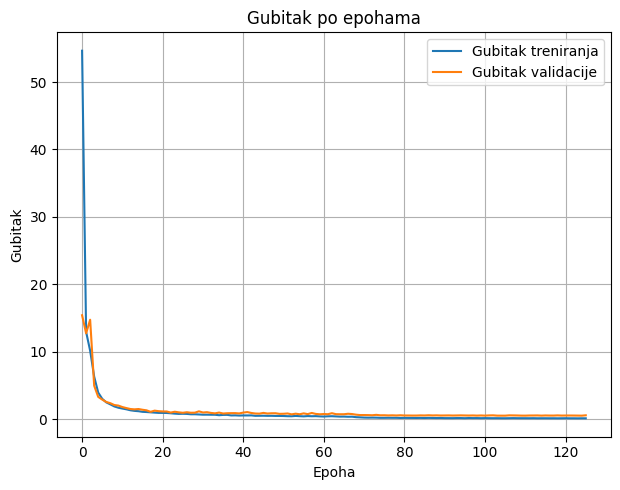

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Gubitak treniranja')
plt.plot(h.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### 4.1.2) Testiranje modela

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
CTC Decode
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step


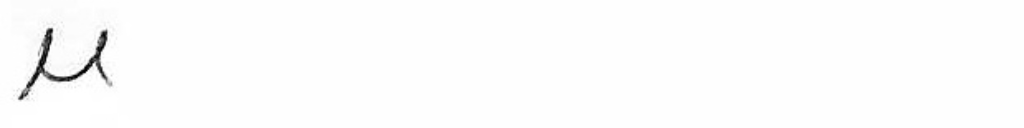

Ispravna labela:  U
Predikcija modela:  U 




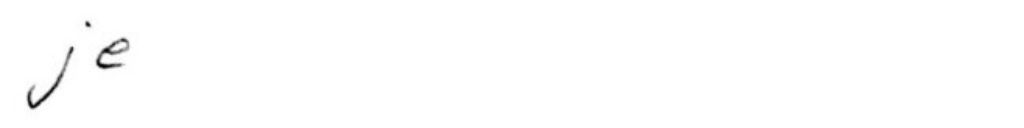

Ispravna labela:  JE
Predikcija modela:  JE 




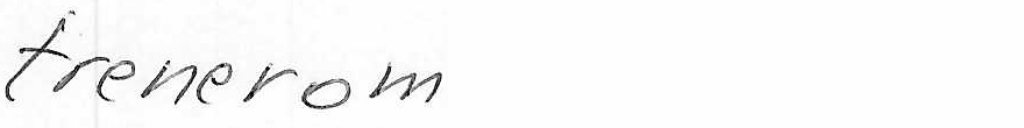

Ispravna labela:  TRENEROM
Predikcija modela:  TRENEROM 




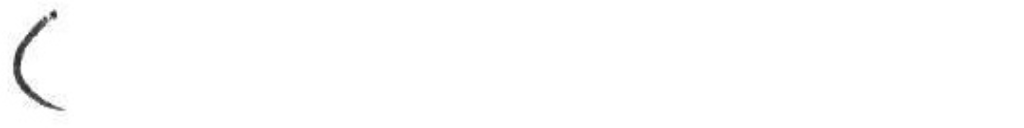

Ispravna labela:  (
Predikcija modela:  ( 




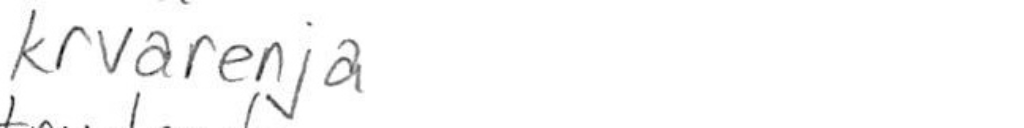

Ispravna labela:  KRVARENJA
Predikcija modela:  KRVARENJA 




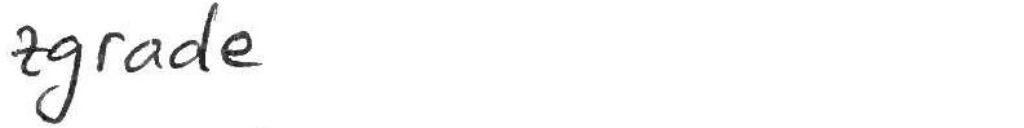

Ispravna labela:  ZGRADE
Predikcija modela:  ZGRADE 




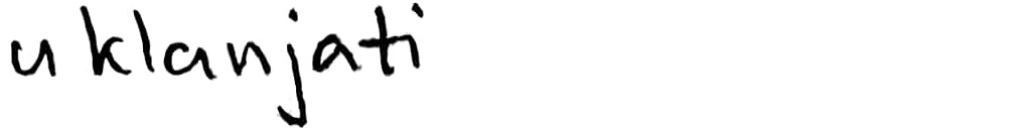

Ispravna labela:  UKLANJATI
Predikcija modela:  UKLANJATI 




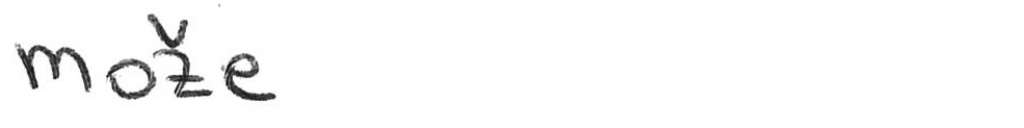

Ispravna labela:  MOŽE
Predikcija modela:  MOŽE 




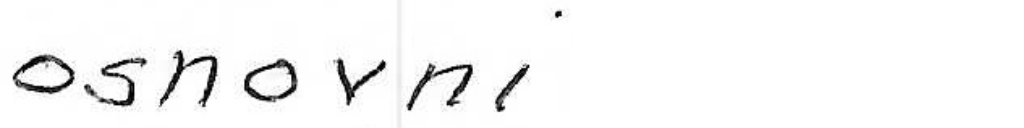

Ispravna labela:  OPISANI
Predikcija modela:  OSNOVNI 




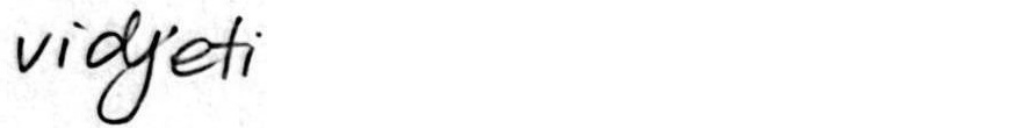

Ispravna labela:  VIDJETI
Predikcija modela:  VIDJETI 




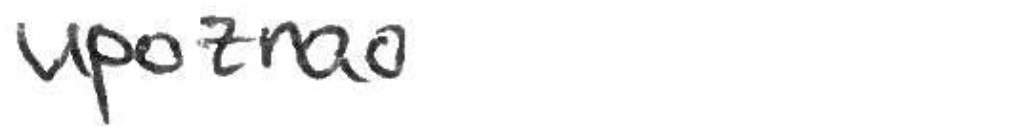

Ispravna labela:  UPOZNAO
Predikcija modela:  UPOZNAO 




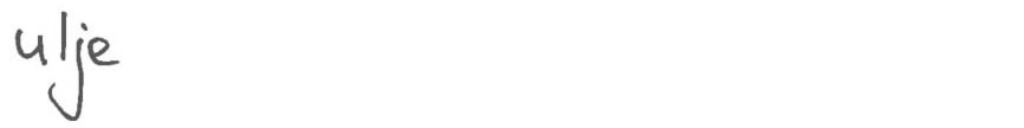

Ispravna labela:  ULJE
Predikcija modela:  ULJE 




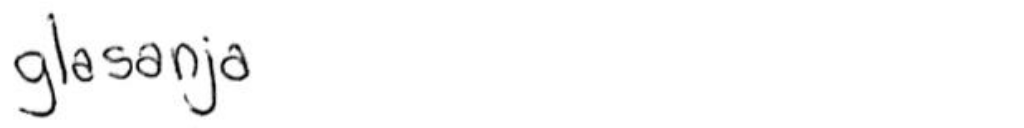

Ispravna labela:  GLASANJA
Predikcija modela:  GLASANJA 




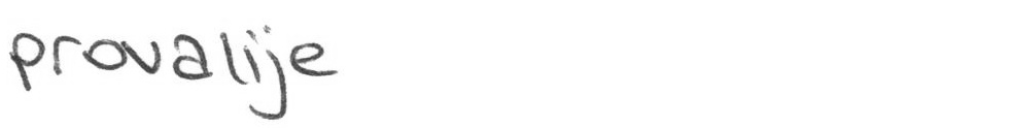

Ispravna labela:  PROVALIJE
Predikcija modela:  PROVALIJE 




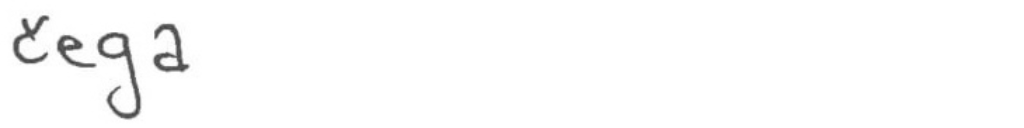

Ispravna labela:  ČEGA
Predikcija modela:  ČEGA 




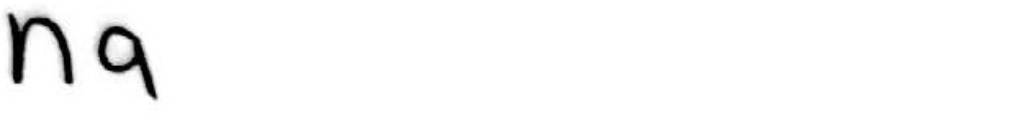

Ispravna labela:  NA
Predikcija modela:  NA 




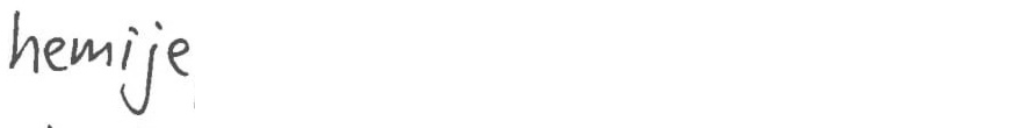

Ispravna labela:  HEMIJE
Predikcija modela:  HEMIJE 




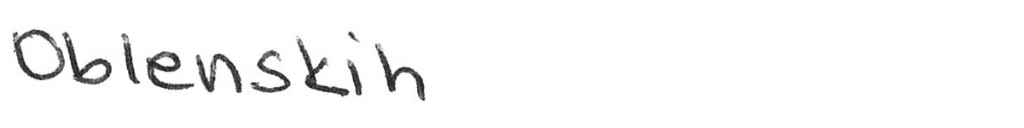

Ispravna labela:  OBLENSKIH
Predikcija modela:  OBLENSKIH 




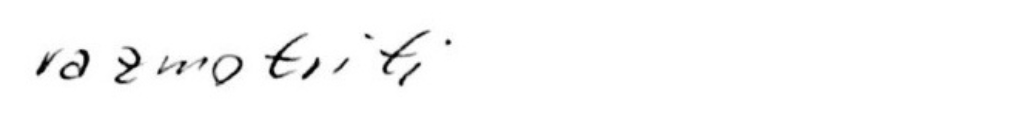

Ispravna labela:  RAZMOTRITI
Predikcija modela:  RAZMOTRITI 




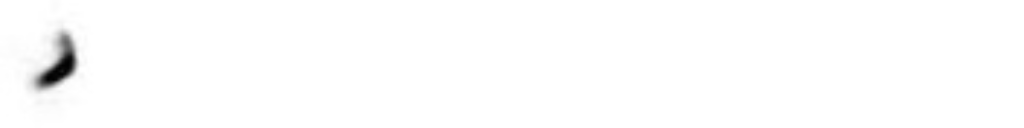

Ispravna labela:  ,
Predikcija modela:  , 



In [ ]:
# Prikaz prvih 20 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:20]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

##### 4.1.3) Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1160
Total time:           0:01:08.301057
Time per item:        0:00:00.058880

Metrics:
Character Error Rate: 0.03117975
Word Error Rate:      0.09310345
Sequence Error Rate:  0.09310345


#### 4.2) Treniranje na linijama teksta prije modifikacije funkcije koja izdvaja linije

In [ ]:
import datetime
import string

source = "labels_l"
arch = "flor"
epochs = 1000
batch_size = 16 # Manji batch size

source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

input_size = (1024, 128, 1)
max_text_length = 256
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_l.hdf5
output ../output/labels_l/flor
target ../output/labels_l/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

[train] Skipped 2 samples with labels longer than max_time_steps (256)
Train images: 1045
Validation images: 300
Test images: 150


In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

In [ ]:
start_time = datetime.datetime.now()

# Treniranje modela
h1 = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h1.history['loss']
val_loss = h1.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 307.6490
Epoch 1: val_loss improved from inf to 136.50014, saving model to ../output/labels_l/flor/checkpoint_weights.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - loss: 305.8520 - val_loss: 136.5001 - learning_rate: 0.0010
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 129.0988
Epoch 2: val_loss improved from 136.50014 to 133.23181, saving model to ../output/labels_l/flor/checkpoint_weights.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - loss: 129.0806 - val_loss: 133.2318 - learning_rate: 0.0010
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 120.8199
Epoch 3: val_loss improved from 133.23181 to 121.61711, saving model to ../output/labels_l/flor/checkpoint_weights.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - loss: 120.7756 - val_loss: 121.6171 - learning_rate: 0.0010
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 111.4264
Epoch 4: val_loss improved from 

##### 4.2.1) Plot

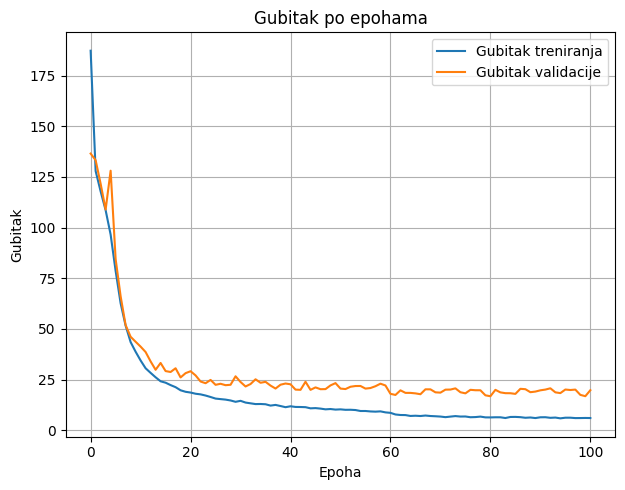

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h1.history['loss'], label='Gubitak treniranja')
plt.plot(h1.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### 4.2.2) Testiranje

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
CTC Decode
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 851ms/step


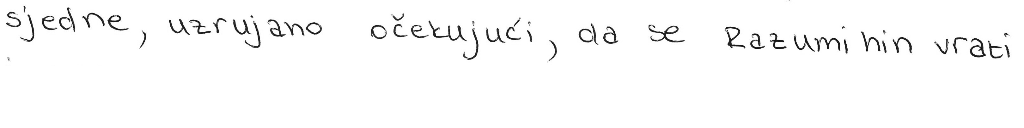

Ispravna labela:  SJEDNE , UZRUJANO OČEKUJUĆI , DA SE RUZUMIHIN VRATI
Predikcija modela:  SJEDNE , UZRUJANO OČEKUJUĆI , DA SE RAZUMIHIN VRATI 




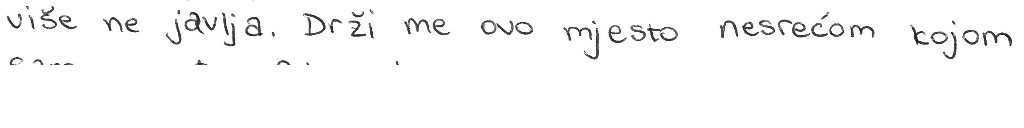

Ispravna labela:  VIŠE NE JAVLJA . DRŽI ME OVO MJESTO NESREĆOM KOJOM
Predikcija modela:  VIŠE NE JAVLJA . DRŽI ME OVO MJESTO NESREĆOM KOJOM 




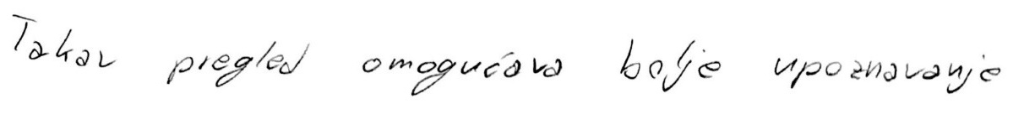

Ispravna labela:  TAKAV PREGLED OMOGUĆAVA BOLJE UPOZNAVANJE
Predikcija modela:  TAKAV PREGLAD OMOGUCAVA BOLJE UPOZNAVANJE 




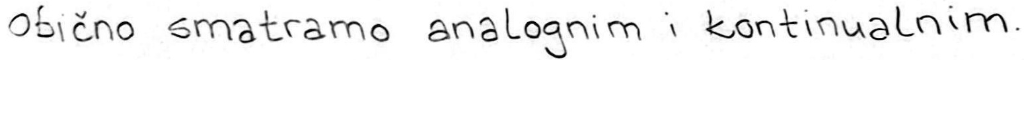

Ispravna labela:  OBIČNO SMATRAMO ANALOGNIM I KONTINUALNIM .
Predikcija modela:  OBIČNO SMATRAMO ANALOGNIM I KONTINUALNIM . 




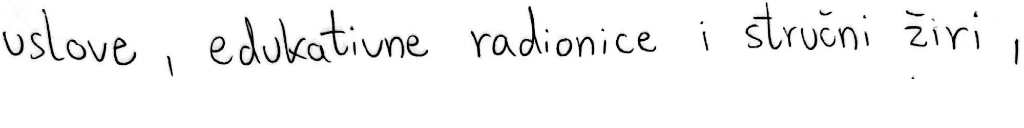

Ispravna labela:  USLOVE , EDUKATIVNE RADIONICE I STRUČNI ŽIRI ,
Predikcija modela:  USLOVE , EDUKATIVNE RADIONICE I STRUČNI ŽIRI , 




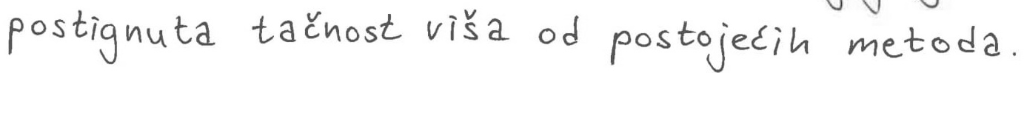

Ispravna labela:  POSTIGNUTA TAČNOST VIŠA OD POSTOJEĆIH METODA .
Predikcija modela:  POSTIGNUTA TAČNOST VIŠA OD POSTOJEĆIH METODA . 




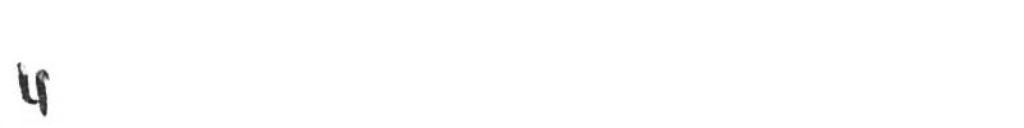

Ispravna labela:  "
Predikcija modela:  , 




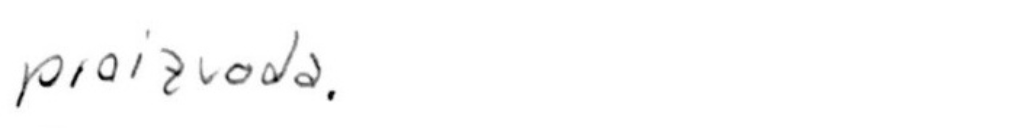

Ispravna labela:  PROIZVODA.
Predikcija modela:  PROIZVODA. 




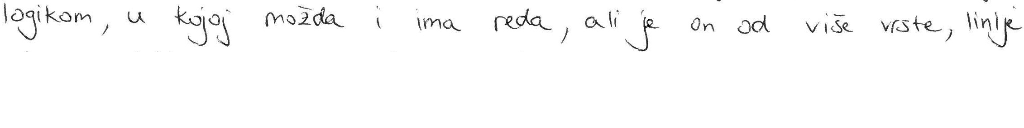

Ispravna labela:  LOGIKOM , U KOJOJ MOŽDA I IMA REDA , ALI JE ON OD VIŠE VRSTE , LINIJE
Predikcija modela:  TOGIKOM , U KOJOJ MOŽDA I IMA REDA , ALI JE ON OD VIŠE VRSTE , LINIJE 




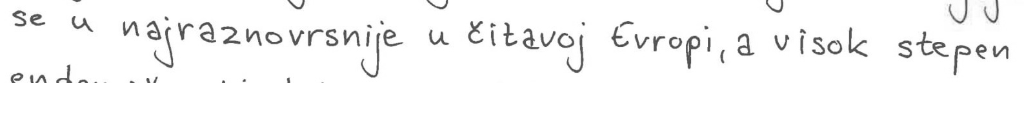

Ispravna labela:  SE U NAJRAZNOVRSNIJE U ČITAVOJ EVROPI , A VISOK STEPEN
Predikcija modela:  SE U NAJRAZNOVRSNIJE U ČITAVOJ EVROPI , A VISOK STEPEN 




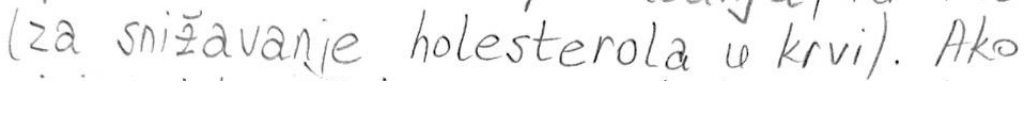

Ispravna labela:  ( ZA SNIŽAVANJE HOLESTEROLA U KRVI ) . AKO
Predikcija modela:  LZA SNIŽAVANJE HOLESTEROLA U KRVI) . AKO 




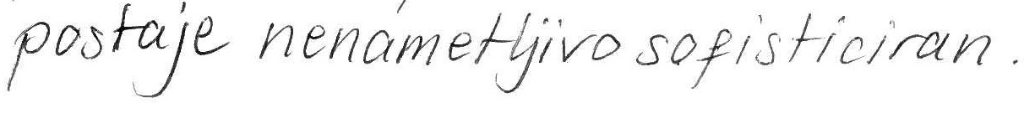

Ispravna labela:  POSTAJE NENAMETLJIVO SOFISTICIRAN .
Predikcija modela:  POSTAJE NENAMETLJIVOSOFISTICINAN . 




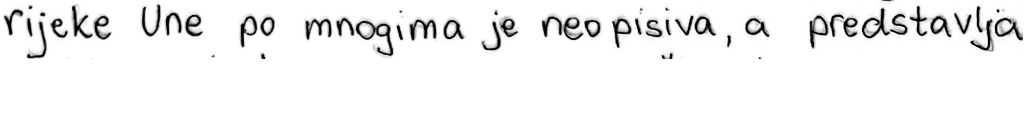

Ispravna labela:  RIJEKE UNE PO MNOGIMA JE NEOPISIVA , A PREDSTAVLJA
Predikcija modela:  RIJEKE UNE PO MNOGIMA JE NEOPISIVA , A PREDSTAVLJA 




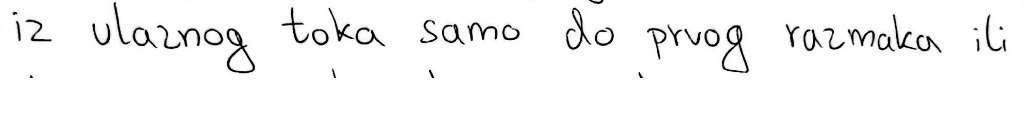

Ispravna labela:  IZ ULAZNOG TOKA SAMO DO PRVOG RAZMAKA ILI
Predikcija modela:  IZ ULAZNOG TOKA SAMO DO PRVOG RAZMAKA ILI 




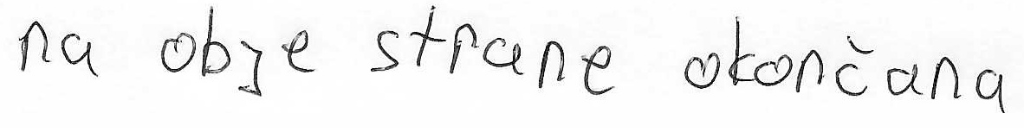

Ispravna labela:  NA OBJE STRANE OKONČANA
Predikcija modela:  NA OBJE STRENE OKONČANA 




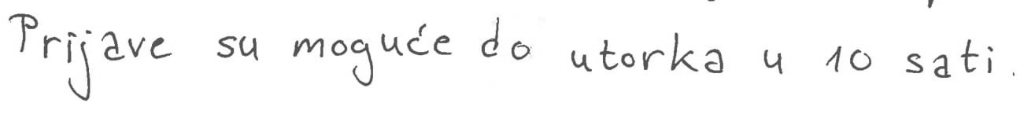

Ispravna labela:  PRIJAVE SU MOGUĆE DO UTORKA U 10 SATI .
Predikcija modela:  PRIJAVE SU MOGUĆE DO UTORKA U 10 SATI . 




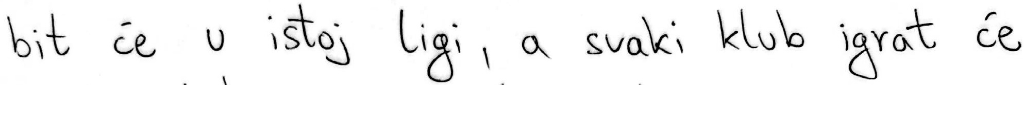

Ispravna labela:  BIT ĆE U ISTOJ LIGI , A SVAKI KLUB IGRAT ĆE
Predikcija modela:  BIT ĆE U ISTOJ LIGI , A SVAKI KLUB IGRAT ĆE 




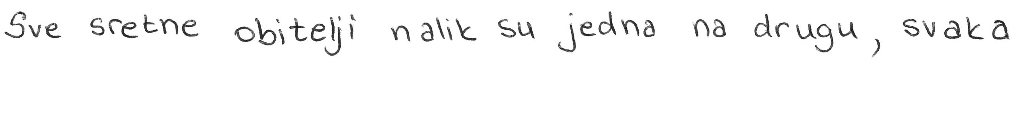

Ispravna labela:  SVE SRETNE OBITELJI NALIK SU JEDNA NA DRUGU SVAKA
Predikcija modela:  SVE SRETNE OBITELJI NALIK SU JEDNA NA DRUGU , SVAKA 




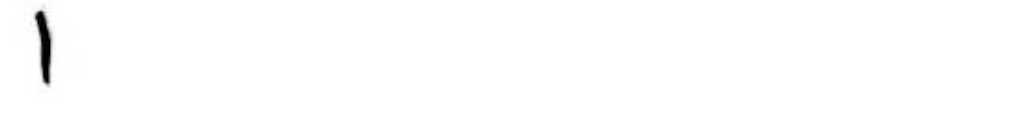

Ispravna labela:  ,
Predikcija modela:  , 




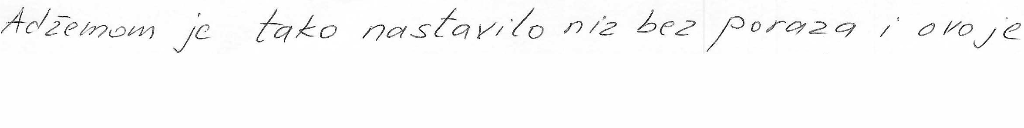

Ispravna labela:  ADŽEMOM JE TAKO NASTAVILO NIZ BEZ PORAZA I OVO JE
Predikcija modela:  ADŽEMOM JE TAKO NASTAVILO NIE BEZ PORAZA I OVO JE 



In [ ]:
# Prikaz prvih 20 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:20]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

##### 4.2.3) Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    150
Total time:           0:00:13.680372
Time per item:        0:00:00.091202

Metrics:
Character Error Rate: 0.05774152
Word Error Rate:      0.16951511
Sequence Error Rate:  0.58666667


#### 4.3) Treniranje na linijama teksta nakon modifikacije funkcije koja izdvaja linije

In [ ]:
import datetime
import string

source = "labels_l_m"
arch = "flor"
epochs = 1000
batch_size = 16 # Manji batch size

source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

input_size = (1024, 128, 1)
max_text_length = 256
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_l_m.hdf5
output ../output/labels_l_m/flor
target ../output/labels_l_m/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 951
Validation images: 272
Test images: 136


In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

In [ ]:
start_time = datetime.datetime.now()

# Treniranje modela
h2 = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h2.history['loss']
val_loss = h2.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 329.8333
Epoch 1: val_loss improved from inf to 150.10719, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 331ms/step - loss: 327.7696 - val_loss: 150.1072 - learning_rate: 0.0010
Epoch 2/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 143.1841
Epoch 2: val_loss improved from 150.10719 to 143.79726, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - loss: 143.1244 - val_loss: 143.7973 - learning_rate: 0.0010
Epoch 3/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 127.7626
Epoch 3: val_loss improved from 143.79726 to 125.12148, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - loss: 127.6949 - val_loss: 125.1215 - learning_rate: 0.0010
Epoch 4/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 108.3166
Epoch 4: val_loss did not 

##### 4.3.1) Plot

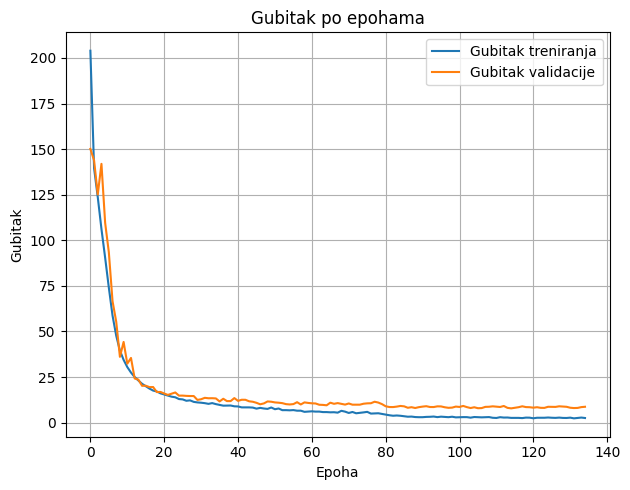

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h2.history['loss'], label='Gubitak treniranja')
plt.plot(h2.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### 4.3.2) Testiranje

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
CTC Decode
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


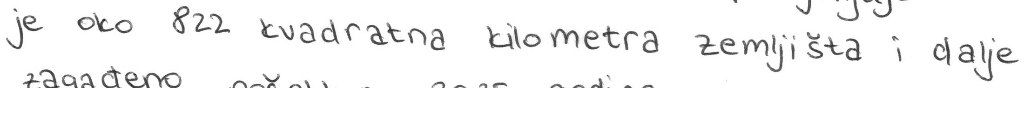

Ispravna labela:  JE OKO 822 KVADRATNA KILOMETRA ZEMLJIŠTA I DALJE
Predikcija modela:  JE OBO SZ KVADRATNA KILOMETRA ZEMLJIŠTA I DALJE 




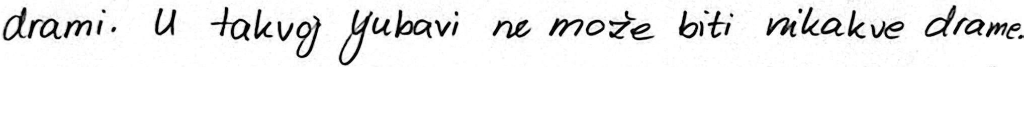

Ispravna labela:  DRAMI. U TAKVOJ LJUBAVI NE MOŽE BITI NIKAKVE DRAME.
Predikcija modela:  DRAMI. U TAKVOJ LJUBAVI NE MOŽE BITI NIKAKVE DRAME, 




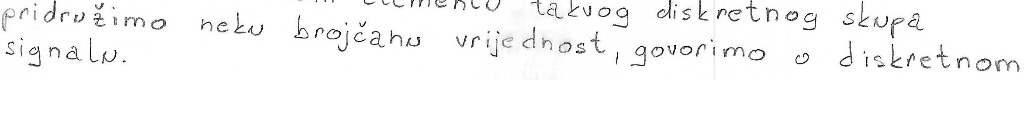

Ispravna labela:  PRIDRUŽIMO NEKU BROJČANU VRIJEDNOST, GOVORIMO O DISKRETNOM
Predikcija modela:  SIGARAŽIMO NEKU BROJČANU URIJEDNOST GOLISRKINATNOG SKUKRATNOM 




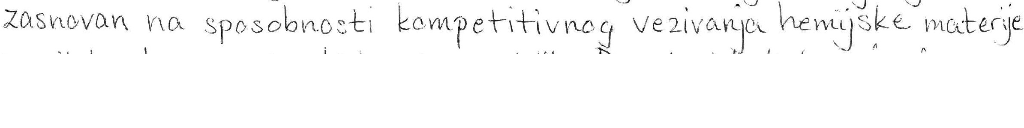

Ispravna labela:  ZASNOVAN NA SPOSOBNOSTI KOMPETITIVNOG VEZIVANJA HEMIJSKE MATERIJE
Predikcija modela:  ZASNOVAN NA SPOSOBNOSTI KOMPETITIVNOG VEZIVANJA HEMIJŠKE MATERIJE 




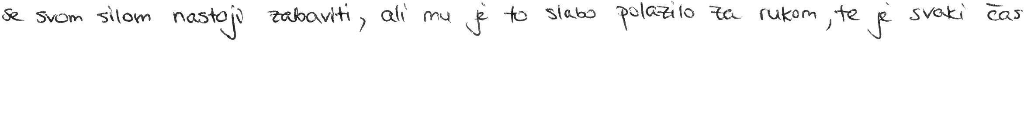

Ispravna labela:  SE SVOM SILOM NASTOJI ZABAVITI, ALI MU JE TO SLABO POLAZILO ZA RUKOM, TE JE SVAKI ČAS
Predikcija modela:  SE SVOM SILOM NASTOJU ZABAVITI, ALI MU J TO SLABO POLOZILO ZA RUKOM, TE JE SVAKI ČAS 




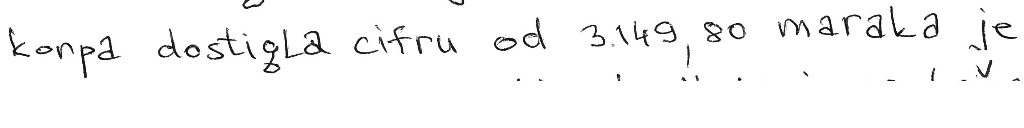

Ispravna labela:  KORPA DOSTIGLA CIFRU OD 3. 149, 80 MARAKA JE
Predikcija modela:  KONPA DOSTISLA CIFRU OD 3149, 30 MARAKA JE 




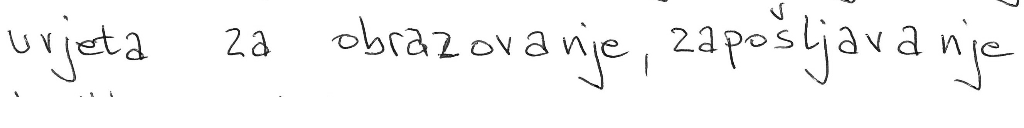

Ispravna labela:  UVJETA ZA OBRAZOVANJE, ZAPOŠLJAVANJE
Predikcija modela:  VRJETA ZA OBRAZOVANJE, ZAPOSLJAVANJE 




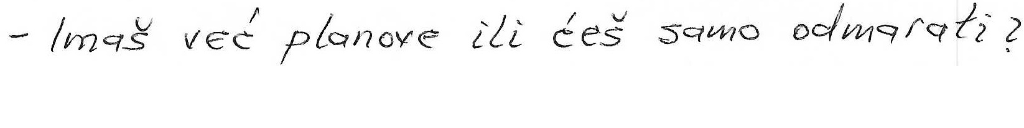

Ispravna labela:  - IMAŠ VEĆ PLANOVE ILI ĆEŠ SAMO ODMARATI?
Predikcija modela:  - IMAŠ VEĆ PLANORE ILI ĆEŠ SAVNO ODMARATI? 




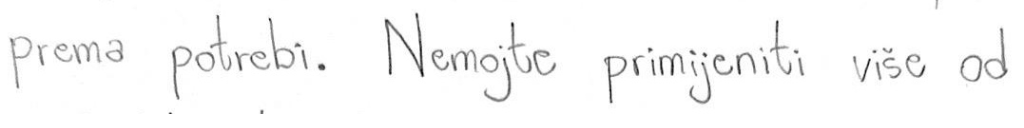

Ispravna labela:  PREMA POTREBI. NEMOJTE PRIMIJENITI VIŠE OD
Predikcija modela:  PREMA POTREBI. NEMOJTE PRIMIJENITI VIŠE OD 




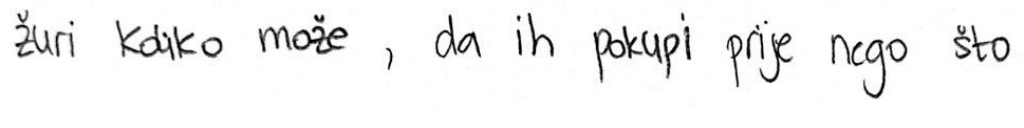

Ispravna labela:  ŽURI KOLIKO MOŽE, DA IH POKUPI PRIJE NEGO ŠTO
Predikcija modela:  ŽURI KOLIKO MOŽE, DA IH POKUPI PRIJE NEGO ŠTO 




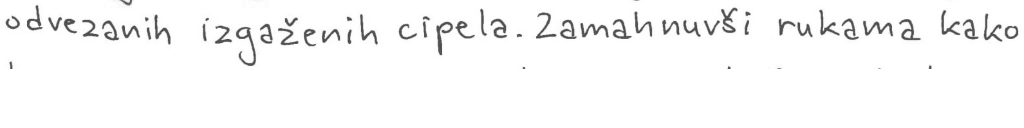

Ispravna labela:  ODVEZANIH IZGAŽENIH CIPELA. ZAMAHNUVŠI RUKAMA KAKO
Predikcija modela:  ODVEZANIH IZGAŽENIH CIPELA. ZAMAHNUVŠI RUKAMA KAKO 




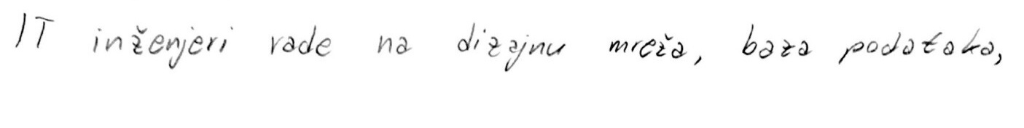

Ispravna labela:  IT INŽENJERI RADE NA DIZAJNU RMEŽA, BAZA PODATAKA
Predikcija modela:  17 INŽENJERI RADE NA DIZAJNU MREŽA, BAZA PODATAKA, 




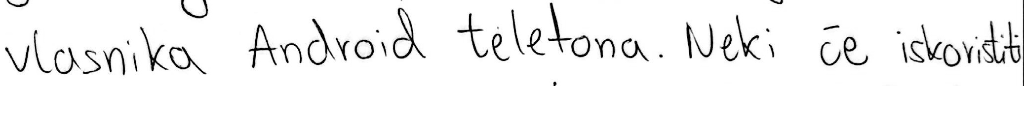

Ispravna labela:  VLASNIKA ANDROID TELEFONA. NEKI ĆE ISKORISTITI
Predikcija modela:  VLASNIKA HNDROID TELETONA. IVEKI ĆE ISKORISTITI 




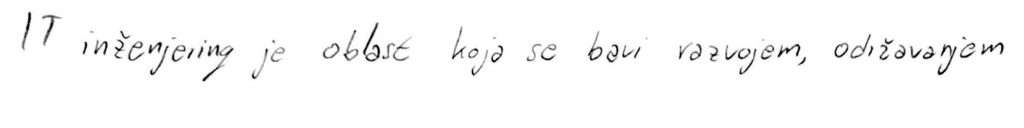

Ispravna labela:  IT INŽENJERING JE OBLAST KOJA SE BAVI RAZVOJEM, ODRŽAVANJEM
Predikcija modela:  1? INŽENJERINJ JE OBLASĆ KOJA SE BAVI RAZVOJEM, ODIŽAVANJEM 




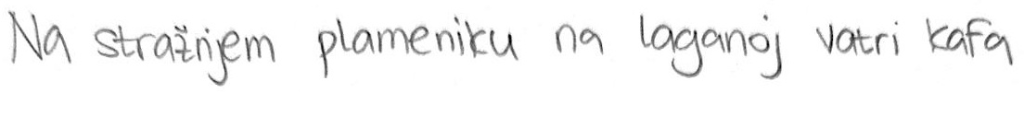

Ispravna labela:  NA STRAŽNJEM PLAMENIKU NA LAGANOJ VATRI KAFA
Predikcija modela:  NA STRAŽNJEM PLAMENIKU NA LAGANOJ VATRI KAFA 




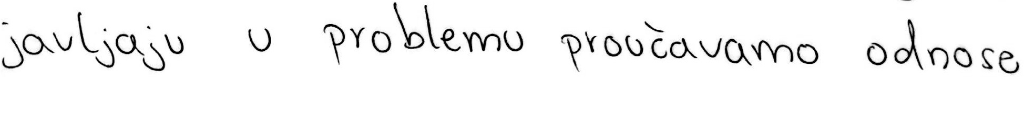

Ispravna labela:  JAVLJAJU U PROBLEMU PROUČAVAMO ODNOSE
Predikcija modela:  JAVLJAJU U PROBLEMU PROUČAVAMO ODNOSE 




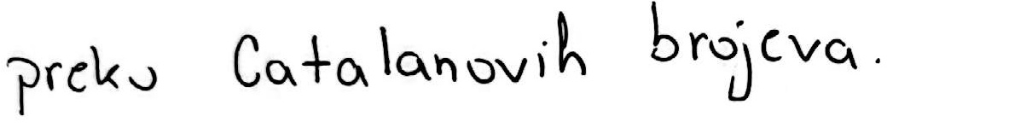

Ispravna labela:  PREKO CATALANOVIH BROJEVA.
Predikcija modela:  PREKU CATALANOVIH BROJEVA. 




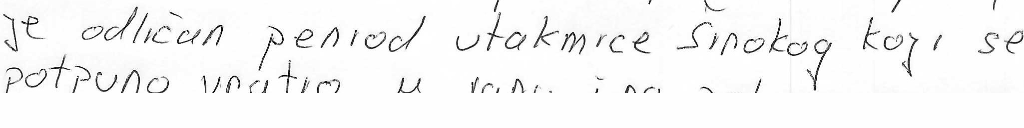

Ispravna labela:  JE ODLIČAN PERIOD UTAKMICE ŠIROKOG KOJI SE
Predikcija modela:  JETRDCN PRENIOD UTAKMICE ŠINOKO? KOJI SE 




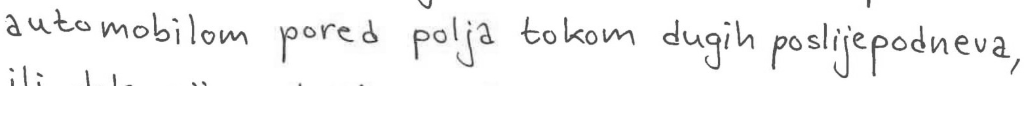

Ispravna labela:  AUTOMOBILOM PORED POLJA TOKOM DUGIH POSLIJEPODNEVA,
Predikcija modela:  AUTOMOBILOM PORED POLJA TOKOM DUGIH POSLIJEPODNEVA, 




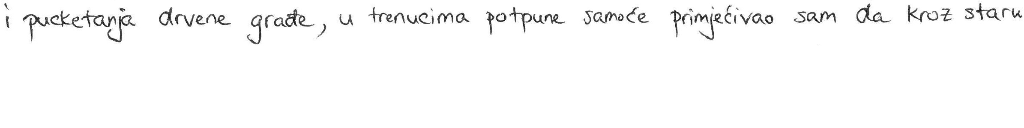

Ispravna labela:  I PUCKETANJA DRVENE GRAĐE, U TRENUCIMA POTPUNE SAMOĆE PRIMJEĆIVAO SAM DA KROZ STARU
Predikcija modela:  I POEKETANJA DRVENE GRAĐE, U TRENUCIMA POTPUNE SANOĆE PRIMJETIVAO SAM DA KROZ STARU 



In [ ]:
# Prikaz prvih 20 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:20]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

##### 4.3.3) Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    136
Total time:           0:00:11.308812
Time per item:        0:00:00.083153

Metrics:
Character Error Rate: 0.05498853
Word Error Rate:      0.19529707
Sequence Error Rate:  0.61029412
